In [1]:
import numpy as np
from numpy import kron
import math
from math import sqrt
from random import random


import matplotlib.pyplot as plt
import matplotlib as mpl

from itertools import product

from matplotlib import colors

import time

from tqdm import tqdm

## $f_{\epsilon}$ function

In [2]:
def f(eps):
    if eps<=1/4:
        f = 1/2 + eps - (1-4*eps)/(2*np.sqrt(1-2*eps))
    else:
        f=1/2+eps
    return f

In [3]:
f(0.01)

0.025126778614938894

## The Distribution with White noise at the Source and meaurment

$|\psi> = \lambda_0 |01> + \lambda_1 |10>$

$\rho = (1-W)  |\psi><\psi| + \frac{W}{4}  I$ 




$M_{x_1,x_2} = (1-\eta)|\phi_{x_1,x_2}><\phi_{x_1,x_2}| + \eta \frac{I}{4} $

In [4]:
def new_index(x):   # 012345 --> 123450
    b  = bin(x)[2:].zfill(6) # x in binary b0..b5
    y = int(b[1:]+b[0], 2)
    return y

def change_qbit_order(x): # 012345 --> 123450
    x_ordered = np.zeros_like(x)
    for i in range(64):
        for j in range(64):
            x_ordered[new_index(i), new_index(j)] = x[i,j]
    return x_ordered


def PP(w,z,u,v,lambda_0,lambda_1, eta, W):
    
## settign states
    state_0 = np.array([1,0])
    state_1 = np.array([0,1])
    
    state_00 = kron(state_0,state_0).reshape(4,1)
    state_01 = kron(state_0,state_1).reshape(4,1)
    state_10 = kron(state_1,state_0).reshape(4,1)
    state_11 = kron(state_1,state_1).reshape(4,1)
    
    psi = (lambda_0*state_01 + lambda_1*state_10)
    
    
    rho_noiseless = np.dot(psi, psi.T)
    
    # add noise for source:
    rho = (1-W)*rho_noiseless + (W/4)*np.identity(4)
    
    total_rho = kron(kron(rho,rho),rho)
    
    total_rho_ordered = change_qbit_order(total_rho)

    
## Setting Measurment 
    out_00 = z*state_00 + w*state_11
    out_01 = w*state_00 - z*state_11
    out_10 = u*state_01 + v*state_10
    out_11 = v*state_01 - u*state_10
    
    
    M_00 = (1-eta)*np.dot(out_00, out_00.T) + (eta/4)*np.identity(4)
    M_01 = (1-eta)*np.dot(out_01, out_01.T) + (eta/4)*np.identity(4)
    M_10 = (1-eta)*np.dot(out_10, out_10.T) + (eta/4)*np.identity(4)
    M_11 = (1-eta)*np.dot(out_11, out_11.T) + (eta/4)*np.identity(4)
    
    M = np.array([[M_00, M_01],[M_10, M_11]])
    
    ## Resulting distribution
    
    p = np.zeros((2,2,2,2,2,2))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
    
        total_M = kron(kron(M[a1,a2], M[b1,b2]), M[c1,c2])
        
        p[a1,a2,b1,b2,c1,c2] = np.trace(np.dot(total_M, total_rho_ordered))

    return p

# find epsilon...... it only depens on  V !!!

#%%
import sys
import mosek
import scipy.sparse as sp
# Since the value of infinity is ignored, we define it solely
# for symbolic purposes
inf = 1.0

# Define a stream printer to grab output from MOSEK
def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()
    
def main_for_LP(c, A_eq, b_eq, A_ub ,b_ub, verbose=False):
    # Create a task object
    A = np.vstack((A_eq,A_ub))
    A = sp.coo_matrix(A)
    
    with mosek.Env() as env:
        with env.Task(0, 0) as task:
            # Attach a log stream printer to the task
            if verbose:
                task.set_Stream(mosek.streamtype.log, streamprinter)
    
            # Bound keys for constraints
            bkc = [mosek.boundkey.fx for i in range(len(A_eq))]+[mosek.boundkey.ra for i in range(len(A_ub))]
    
            # Bound values for constraints
            buc = list(b_eq)+list(b_ub)
            blc = list(b_eq)+[-inf for i in range(len(buc))]
            
            # Bound keys for variables
            bkx = [mosek.boundkey.ra for i in range(len(c))]
    
            # Bound values for variables
            blx = [0.0 for i in range(len(c))]
            bux = [1.0 for i in range(len(c))]
    
            numvar = len(bkx)
            numcon = len(bkc)

            # Append 'numcon' empty constraints.
            # The constraints will initially have no bounds.
            task.appendcons(numcon)
    
            # Append 'numvar' variables.
            # The variables will initially be fixed at zero (x=0).
            task.appendvars(numvar)
    
            for j in range(numvar):
                # Set the linear term c_j in the objective.
                task.putcj(j, c[j])
    
                # Set the bounds on variable j
                # blx[j] <= x_j <= bux[j]
                task.putvarbound(j, bkx[j], blx[j], bux[j])
    
                # Input column j of A
            task.putaijlist(list(A.row),list(A.col),list(A.data))          
    
            # Set the bounds on constraints.
             # blc[i] <= constraint_i <= buc[i]
            for i in range(numcon):
                task.putconbound(i, bkc[i], blc[i], buc[i])
    
            # Input the objective sense (minimize/maximize)
            task.putobjsense(mosek.objsense.minimize)
    
            # Solve the problem
            task.optimize()
            # Print a summary containing information
            # about the solution for debugging purposes
            if verbose:
                task.solutionsummary(mosek.streamtype.msg)
    
            # Get status information about the solution
            solsta = task.getsolsta(mosek.soltype.bas)
            
            # Get the result!
            xx = [0.0]*numvar
            task.getxx(mosek.soltype.itr, xx)
            
            
    
            #if (solsta == mosek.solsta.optimal):
            #xx = [0.0] * numvar
            #task.getxx(mosek.soltype.itr, xx)
                #print("Optimal solution: ")
                #for i in range(numvar):
                #    print("x[" + str(i) + "]=" + str(xx[i]))
            #elif (solsta == mosek.solsta.dual_infeas_cer or
            #      solsta == mosek.solsta.prim_infeas_cer):
            #    if verbose:
            #        print("Primal or dual infeasibility certificate found.\n")
            #elif solsta == mosek.solsta.unknown:
            #    print("Unknown solution status")
            #else:
            #    print("Other solution status")
            #obje = task.getprimalobj(mosek.soltype.itr)
            #if verbose:
            #    print(obje)
            return solsta, xx
        
        


/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Find $\epsilon : $ $P$(not PTC)

In [6]:
def find_eps(eta, W):
    
    return 1/2*(1-((1-eta)*(1-W))**3)

# Single experiment with white noise

### The LP:

$$P_{obs}(a_1,a_2,b_1,b_2,c_1,c_2) = P_{PTC}^{New}(a_1,a_2,b_1,b_2,c_1,c_2) + 2\epsilon ~ x(a_1,a_2,b_1,b_2,c_1,c_2) - 2\epsilon ~ y(a_1,a_2,b_1,b_2,c_1,c_2) = \sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{P(a_2,b_2,c_2, t_a, t_b, t_c)} + 2\epsilon ~ x(a_1,a_2,b_1,b_2,c_1,c_2) - 2\epsilon ~ y(a_1,a_2,b_1,b_2,c_1,c_2) $$


$$ \sum x(a_1,a_2,b_1,b_2,c_1,c_2) = 1 = y(a_1,a_2,b_1,b_2,c_1,c_2)$$


$x(a_2,b_2,c_2) =  y(a_2,b_2,c_2) \Rightarrow \sum_{a_1,b_1,c_1} x(a_1,a_2,b_1,b_2,c_1,c_2) =  \sum_{a_1,b_1,c_1} y(a_1,a_2,b_1,b_2,c_1,c_2)$


and Network constraint:

$$P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow q(t_a = 1) \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} -  q(t_a = 0) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c) = 0$$



$$ q_{low} = \frac{1}{2}(1+\sqrt{\frac{(E_A^{obs}-4 \epsilon)(E_A^{obs}-4 \epsilon)}{E_A^{obs}+4 \epsilon}}) \leq q(t_a = 1) = \frac{1}{2}(1+\sqrt{\frac{E_B E_C}{E_A}}) \leq \frac{1}{2}(1+\sqrt{\frac{(E_A^{obs}+4 \epsilon)(E_A^{obs}+4 \epsilon)}{E_A^{obs}-4 \epsilon}}) = q_{up}$$



or "3 $\epsilon$" if we compute E_A^{obs} only for a,b,c which are PTC 


By Symetry we have: 



$$ q_{low} \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} - (1-q_{low}) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c) \leq 0 \leq q_{up} \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} - (1-q_{up}) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c)$$


In [9]:
def get_single_exp_mosek(l0, eta, W, phi_u, phi_w, honest_q=False, N_grid_q=1):  
    
    l1 = np.sqrt(1-l0**2)
    
    # find epsilon
    eps = find_eps(eta, W)

    
    q = l0**2  #probability of sending token to right/left

    q_a = [q, 1-q]
    q_b = [q, 1-q]
    q_c = [q, 1-q]
    

    c = np.zeros(64*3)  # number of vars 64*3 = 192 ....


    # Form the matrix A

    #First we consider the probability constraints 

    A_1 = np.zeros((64, 64*3))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        for ta,tb,tc in product(range(2), repeat=3): 
            if (a1 == (tb+tc+1)%2) and (b1 == (ta+tc+1)%2) and (c1 == (ta+tb+1)%2): # ParityCheck
                var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
                A_1[constraint_it, var_it] = 1
        A_1[constraint_it, constraint_it+64] = f(eps)  # ---> x coef
        A_1[constraint_it, constraint_it+(64*2)] = -f(eps)  # ---> y coef


    #Normalization for x and y
    A_1_norm_xy = np.zeros((1, 64*3))    

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        temp = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        A_1_norm_xy[0, temp+64] = 1 # ---> x coef
        #A_1_norm_xy[1, temp+(64*2)] = 1 # ---> y coef

    # sum over a1,b1,c1 for x and y is the same..
    A_x2y2 =  np.zeros((8, 64*3))
    for a2,b2,c2 in product(range(2), repeat=3):  
        constraint_it = np.inner([4,2,1],[a2,b2,c2]) 
        for a1,b1,c1 in product(range(2), repeat=3):
            temp = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
            A_x2y2[constraint_it, temp+64] = 1 # ---> x coef
            A_x2y2[constraint_it, temp+(64*2)] = -1  # ---> y coef


    A_eq = np.concatenate([A_1,A_1_norm_xy,A_x2y2])
    
    
    #form part of b that doesnt depend on distribution
    b_1_normxy = np.ones(1)
    b_x2y2 = np.zeros(8)
    b_3_up = np.zeros(24)
    b_3_low = np.zeros(24)




    prob = PP(np.cos(phi_w), np.sin(phi_w), np.cos(phi_u), np.sin(phi_u),l0,l1, eta, W)


    # Form the vector b            
    b_1 = np.zeros(64)
    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        b_1[constraint_it] = prob[a1,a2,b1,b2,c1,c2]



    b_eq = np.concatenate([b_1,b_1_normxy,b_x2y2])

    b_up = np.concatenate([b_3_up, b_3_low])



    # Continue A
    # Now we consider the network independence constraints
    '''
    E_A_obs = 2*np.sum(prob[1,:,:,:,:,:])-1
    q_up  = 0.5*(1+np.sqrt(E_A_obs+4*eps))   #q_a[1] 
    q_low = 0.5*(1+np.sqrt(E_A_obs-4*eps))   #q_a[1]
    '''

    if honest_q == False:

        E_A_obs_ptc = np.abs(2*(np.sum(prob[0,:,0,:,1,:]) + np.sum(prob[0,:,1,:,0,:]) )-1) #for q_a(0) inside ptc

        delta = 2*f(eps)-eps
        
        q_up_main  = 0.5*(1+((E_A_obs_ptc + delta)/np.sqrt(E_A_obs_ptc - delta)))
        q_up_main  = min(1, q_up_main)

        q_low_main = 0.5*(1+((E_A_obs_ptc - delta)/np.sqrt(E_A_obs_ptc + delta)))
        q_low_main = max(0,q_low_main)

    else:
        q_up_main  = q_a[1]
        q_low_main = q_a[1]


    # Doing the grid search.............

    #N_grid_q => number of subintervals

    q_bounds = np.linspace(q_low_main, q_up_main, N_grid_q+1)

    feasible_q_founded = False

    #for k_a, k_b, k_c in product(range(N_grid_q), repeat=3):   
    for k_a in range(N_grid_q):
        for k_b in range(k_a+1):
            for k_c in range(k_b+1):

                q_low_a = q_bounds[k_a]
                q_up_a = q_bounds[k_a+1]

                q_low_b = q_bounds[k_b]
                q_up_b = q_bounds[k_b+1]

                q_low_c = q_bounds[k_c]
                q_up_c = q_bounds[k_c+1]


                # upper bound...... and lower bound ...............
                A_3a_up = np.zeros((8,64*3))
                A_3a_low = np.zeros((8,64*3))

                for a2,tb,tc in product(range(2),repeat=3):
                    constraint_it = np.inner([4,2,1],[a2,tb,tc])
                    for b2,c2 in product(range(2),repeat=2):
                        var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,0,tb,tc]) # ta = 0
                        var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,1,tb,tc]) # ta = 1
                        A_3a_up[constraint_it, var_it_0] = -q_up_a
                        A_3a_up[constraint_it, var_it_1] = (1-q_up_a)

                        A_3a_low[constraint_it, var_it_0] = q_low_a
                        A_3a_low[constraint_it, var_it_1] = -(1-q_low_a)


                A_3b_up = np.zeros((8,64*3))
                A_3b_low = np.zeros((8,64*3))
                for b2,ta,tc in product(range(2),repeat=3):
                    constraint_it = np.inner([4,2,1],[b2,ta,tc])
                    for a2,c2 in product(range(2),repeat=2):
                        var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,0,tc])# tb = 0
                        var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,1,tc])# tb = 1
                        A_3b_up[constraint_it, var_it_0] = -q_up_b
                        A_3b_up[constraint_it, var_it_1] = (1-q_up_b)

                        A_3b_low[constraint_it, var_it_0] = q_low_b
                        A_3b_low[constraint_it, var_it_1] = -(1-q_low_b)


                A_3c_up = np.zeros((8,64*3))
                A_3c_low = np.zeros((8,64*3))

                for c2,ta,tb in product(range(2),repeat=3):
                    constraint_it = np.inner([4,2,1],[c2,ta,tb])
                    for a2,b2 in product(range(2),repeat=2):
                        var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,0])# tc = 0
                        var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,1])# tc = 1
                        A_3c_up[constraint_it, var_it_0] = -q_up_c
                        A_3c_up[constraint_it, var_it_1] = (1-q_up_c)

                        A_3c_low[constraint_it, var_it_0] = q_low_c
                        A_3c_low[constraint_it, var_it_1] = -(1-q_low_c)




                A_up = np.concatenate([A_3a_up,A_3b_up,A_3c_up, A_3a_low,A_3b_low,A_3c_low]) 


                res, xx = main_for_LP(c, A_eq, b_eq, A_up ,b_up,verbose=False)  

                if res != mosek.solsta.prim_infeas_cer: #if feasible for some qs in the grid
                    feasible_q_founded = True
                    break


    return (feasible_q_founded)*1 #output 1 if feasible!, and output the solution xx

## Noise Plot

In [12]:
def Noise_Plot_Get_Data(mode, l0, param_list, grid_size, honest_q=False, N_grid_q=1):

    tic = time.perf_counter()

    N_it = grid_size

    noise_map = np.zeros((N_it, N_it//2))

    phi_u_list = np.linspace(0, np.pi/2, num = N_it)
    phi_w_list = np.linspace(0, np.pi/4, num = N_it//2)   # we have mirror symemtry for w .......

    for i in tqdm(range(N_it)):
        for j in range(N_it//2):

            phi_u = phi_u_list[i]
            phi_w = phi_w_list[j]

            param_max = 0
            
            for param in param_list:
                
                if mode == "Noisy_Sources":
                    W = param
                    eta = 0
                
                elif mode == "Noisy_Measurments":
                    W = 0
                    eta = param
                
                else:
                    print("mode is ", mode)
                    return("Eroor, mode should be 'Noisy_Sources' or 'Noisy_Measurments' ")
                
            
                feasiblity_flag = get_single_exp_mosek(l0, eta, W, phi_u, phi_w, honest_q, N_grid_q)
                
                if feasiblity_flag: 
                    break
                param_max = param  # saves the last infeasible param
            noise_map[i,j] = param_max

    ## Add the other half side for w
    noise_map_flip = np.flip(noise_map, 1)
    noise_map_final = np.concatenate((noise_map, noise_map_flip), axis=1)

        
    toc = time.perf_counter()
    print("time: ", np.round((toc-tic)/60, 2), " mins")
 
    return noise_map_final 



In [13]:
def Noise_Plot_Show_test(noise_map_final):

    total_map = noise_map_final

    total_map = total_map *100 # in %

    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_title("Noise map")
    plt.imshow(total_map ,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

    # Add colorbar
    
    # Add colorbar
    num_colors=len(np.unique(noise_map_final))
    step = np.min(total_map[np.nonzero(noise_map_final)])
    plt.colorbar(boundaries=np.linspace(0, np.max(total_map)+step, num_colors+1)) # + step foor interval of bouns


    plt.xlabel("$\phi_1 \ [w=cos(\phi_1)]$", size = 14)
    plt.ylabel("$\phi_2 \ [u=cos(\phi_2)]$", size = 14)

    plt.show() 

In [46]:
import matplotlib
import matplotlib.ticker as mtick

def Noise_Plot_Show_new(noise_map_final, name):
    
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    
    #matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...
    

    total_map =   noise_map_final #-0.004*(local_map)

    total_map = total_map 

    fig, ax = plt.subplots(figsize=(8,8))

    #ax.set_title("White Noise Map", size = 20)
    
    plt.imshow(total_map ,origin='lower', extent=[0,np.pi/2,0,np.pi/2])


    
    # Add colorbar
    num_colors=len(np.unique(noise_map_final))
    step = np.min(total_map[np.nonzero(noise_map_final)])
    
    cbar = plt.colorbar(extend="max", boundaries=np.linspace(0, np.max(total_map)+step, num_colors+1)) # + step foor interval of bouns
    #cbar = plt.colorbar(extend="max", boundaries=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]) # + step foor interval of bouns

    cbar.set_ticks([0, 0.001, 0.002, 0.003, 0.004, 0.0046])


    cbar.ax.tick_params(labelsize=16)

    # Format the colorbar to display percentages
    formatter = mtick.FuncFormatter(lambda x, pos: '{:.1%}'.format(x))
    cbar.ax.yaxis.set_major_formatter(formatter)

    plt.xlabel("$\phi_w$", size = 20)
    plt.ylabel("$\phi_u$", size = 20)


    theta = np.linspace(0, np.pi/2, 5)
    plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

    plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])
    
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)


    
    from numpy import unravel_index
    
    phi_u_list = np.linspace(0, np.pi/2, num = grid_size)
    phi_w_list = np.linspace(0, np.pi/4, num = grid_size)

    i_max, j_max = unravel_index(total_map.argmax(), total_map.shape)
    phi_u_max = phi_u_list[i_max]
    phi_w_max = phi_w_list[j_max]

    print("Max r is ", np.max(total_map), "for:")
    print("$phi_1$", phi_w_max)
    print("$ph2_1$", phi_u_max)
    

    fig.savefig(name, bbox_inches='tight') 
    plt.show()

## Noisy sources:

In [ ]:
l0 = np.sqrt(0.222)
W_list = np.linspace(0, 0.0057, 57+1)
grid_size = 50  
honest_q= False
N_grid_q = 16

noise_map_final = Noise_Plot_Get_Data("Noisy_Sources", l0, W_list, grid_size, honest_q, N_grid_q)

Noise_Plot_Show_new(noise_map_final)

Max r is  0.0049 for:
$phi_1$ 0.0
$ph2_1$ 0.41674188261905415


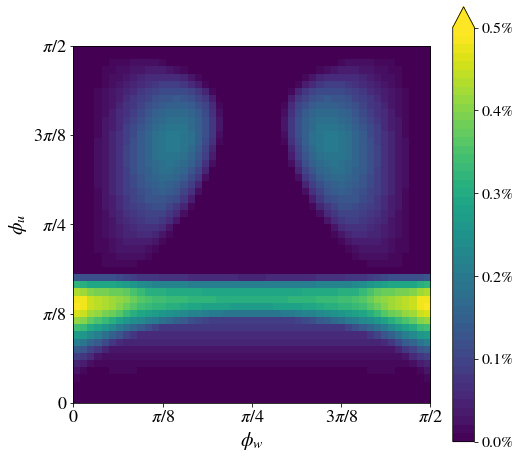

In [33]:
Noise_Plot_Show_new(noise_map_final, 'Source_White_Noise_222.pdf')

## Noisy measurments:

In [ ]:
l0 = np.sqrt(0.222) 
W_list = np.linspace(0, 0.0052, 52+1)
grid_size = 50  
honest_q= False
N_grid_q = 16

noise_map_final = Noise_Plot_Get_Data("Noisy_Measurments", l0, W_list, grid_size, honest_q, N_grid_q)
np.savez('Measurments_noise_222_q16.npz', noise_map_final=noise_map_final, local_map=local_map)
Noise_Plot_Show_test(noise_map_final)

 30%|█████████▉                       | 15/50 [28:52:47<153:24:32, 15779.20s/it]

In [56]:
import matplotlib
import matplotlib.ticker as mtick

def Noise_Plot_Show_new2(noise_map_final, name):
    
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    
    #matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...
    

    total_map =   noise_map_final #-0.004*(local_map)

    total_map = total_map 

    fig, ax = plt.subplots(figsize=(8,8))

    #ax.set_title("White Noise Map", size = 20)
    
    plt.imshow(total_map ,origin='lower', extent=[0,np.pi/2,0,np.pi/2])


    
    # Add colorbar
    num_colors=len(np.unique(noise_map_final))
    step = np.min(total_map[np.nonzero(noise_map_final)])
    
    cbar = plt.colorbar(extend="max", boundaries=np.linspace(0, np.max(total_map)+step, num_colors+1)) # + step foor interval of bouns
    #cbar = plt.colorbar(extend="max", boundaries=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]) # + step foor interval of bouns

    cbar.set_ticks([0, 0.001, 0.002, 0.003, 0.004, 0.0046])


    cbar.ax.tick_params(labelsize=16)

    # Format the colorbar to display percentages
    formatter = mtick.FuncFormatter(lambda x, pos: '{:.2%}'.format(x))
    cbar.ax.yaxis.set_major_formatter(formatter)

    plt.xlabel("$\phi_w$", size = 20)
    plt.ylabel("$\phi_u$", size = 20)


    theta = np.linspace(0, np.pi/2, 5)
    plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

    plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])
    
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)


    
    from numpy import unravel_index
    
    phi_u_list = np.linspace(0, np.pi/2, num = grid_size)
    phi_w_list = np.linspace(0, np.pi/4, num = grid_size)

    i_max, j_max = unravel_index(total_map.argmax(), total_map.shape)
    phi_u_max = phi_u_list[i_max]
    phi_w_max = phi_w_list[j_max]

    print("Max r is ", np.max(total_map), "for:")
    print("$phi_1$", phi_w_max)
    print("$ph2_1$", phi_u_max)
    

    fig.savefig(name, bbox_inches='tight') 
    plt.show()

Max r is  0.0046 for:
$phi_1$ 0.0
$ph2_1$ 0.41674188261905415


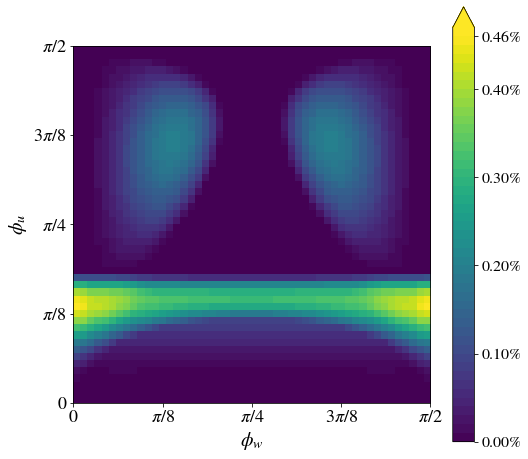

In [57]:
Noise_Plot_Show_new2(noise_map_final, 'Measurement_White_Noise_222.pdf')